<a href="https://colab.research.google.com/github/danplotkin/mastering_rl/blob/main/mastering_rl_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mastering Reinforcement Learning: Theory, Math, and Python
>  _**Part II: Implementing Reinforcement Learning in Python**_

> *Author:  Daniel M. Plotkin*

> *Author Email: danmplotkin@gmail.com*

> *Last Updated: 1/25/2024*

> **[Click to Access Course Homepage](https://github.com/danplotkin/mastering_rl/tree/main?tab=readme-ov-file#mastering-reinforcement-learning-theory-math-and-python)**

# Table of Contents

>[1 - Gynmasium](#scrollTo=kqH0rOvRe_fg)

>[2 - The Cartpole Envirnonment](#scrollTo=PvYBUQpOhMtY)

>[3 - Developing a Cartpole Agent](#scrollTo=Nb6G6CY0p9i5)

>>[A. Install Gymnasium](#scrollTo=HC3L1V8nqBvR)

>>[B. Import Required Libaries](#scrollTo=PGgIuvoJqNcS)

>>[C. Initialize Envirnonment](#scrollTo=bJ7HYFR60kkt)

>>[D. Create Replay Memory](#scrollTo=jODg5INnu0Lt)

>>[E. Build Deep Q-Network](#scrollTo=FDJbefCZzHe2)

>>[F. Define Hyperparameters](#scrollTo=ThZri9Xu05mN)

>>[G. Define Policy and Target Network](#scrollTo=6EJVZB4V2qzU)

>>[H. Create Policy Network Tracker](#scrollTo=ieo-MnXFmobk)

>>[I. Train Agent](#scrollTo=Dk4Cf6283l6x)

>>>[I. Create Math Functions for Training](#scrollTo=25RXohBnekUH)

>>>[II. Create Agent Class](#scrollTo=knMatU44fToj)

>>>[III. Intialize Agent](#scrollTo=09Ue7ohufZl9)

>>>[IV. Train Agent](#scrollTo=wfJLiwvxOHPl)

>>>[V. Evaluate Agent](#scrollTo=I3BZpojZaw9d)

>>[J. Solve Problem](#scrollTo=h_wUaBbxXgxc)



# 1 - Gynmasium

Gymnasium is an open source Python library for developing and comparing reinforcement learning algorithms by providing an API all single agent reinforcement learning environments. Gymnasium is a maintained fork of OpenAI's Gym library. Check out their [documentation](https://gymnasium.farama.org/) for more.

# 2 - The Cartpole Envirnonment

The Cartpole environment is on of the most well known classic reinforcement learning problems offered within the Gynmasium library. It's a simple simulation where a pole is attached to a cart, and the goal is to balance the pole by moving the cart left or right.


<img src="https://bytepawn.com/images/cartpole.gif" alt="Alt text" width="600" height="400" />

> [*Gif Source*](https://bytepawn.com/images/cartpole.gif)

A reward $r_t+1 = 1$ is provided for every time step the pole remains upright. The episode will end when:
- The pole tips over at a certain angle limit.
- The cart moves outside the world edges.
- A maximum number of time steps is reached (500 in this environment).

The goal is to learn a policy that is able to maximize the sum of rewards in an episode.

## Solved Requirements

This problem is considered "solved" when the average reward is greater than or equal to 195.0 over 100 consecutive trials. Source from [OpenAI Gym Github Repo](https://github.com/openai/gym/wiki/CartPole-v0#solved-requirements).

# 3 - Developing a Cartpole Agent

We will now implement our agent using `gynmasium` and `pytorch`.

## A. Install Gymnasium

In [ ]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.2 MB/s eta 0:00:00


## B. Import Required Libaries

In [ ]:
import gymnasium as gym

import random
import math
from collections import namedtuple, deque
from copy import deepcopy
from tqdm.auto import tqdm
from dataclasses import dataclass

import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Specify GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set plotting grid size
plt.rcParams['figure.figsize'] = (10, 6)

## C. Initialize Envirnonment

In [ ]:
env = gym.make("CartPole-v1")

## D. Create Replay Memory

We will initialize our replay memory, which is where we store the agent's experiences at each time step. We will intiaize two classes:

* `Transition` - This will be a named tuple mapping our state-action pairs $(s_t, s_t)$ to their next state and reward $(s_{t+1}, r_{t+1})$.

* `ReplayMemory` - A Buffer of a bounded to a size that holds the transitions observed recently. We will also allow our class to randomly a random batch for traning.

In [ ]:
Transition = namedtuple(
    'Transition',
    ('state', 'action', 'reward', 'next_state')
)


class ReplayMemory:
    """
    Replay memory object for Deep Q Network (DQN).

    Parameters:
    - capacity (int): Maximum capacity of the replay memory.

    Attributes:
    - memory (collections.deque): A deque representing the replay memory with a specified capacity.

    Methods:
    - push(*args): Save a transition into memory.
    - sample(batch_size): Randomly sample a batch of transitions from memory.
    - __len__(): Get the current size (number of transitions) of the replay memory.

    Example Usage:
    ```python
    # Create an instance of ReplayMemory with a capacity of 1000
    memory = ReplayMemory(capacity=1000)

    # Save a transition into memory
    memory.push(state, action, reward, next_state)

    # Randomly sample a batch of transitions
    batch = memory.sample(batch_size=32)

    # Get the current size of the replay memory
    size = len(memory)
    ```
    """
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """
        Save a transition into memory.

        Parameters:
        - *args: Variable number of arguments representing a transition (state, action, reward, next_state).
        """
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """
        Randomly sample a batch from memory.

        Parameters:
        - batch_size: Number of transitions to sample in a batch.

        Returns:
        - list: A list of sampled transitions.
        """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """
        Get the current size (number of transitions) of the replay memory.

        Returns:
        - int: Current size of the replay memory.
        """
        return len(self.memory)

## E. Build Deep Q-Network

We will build are Deep Q-Network using `PyTorch`.

In [ ]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_observations, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        return self.network(x)

## F. Define Hyperparameters

We need to define some hyperparameters to train our agent. Instead of just blindly creating variables, we will organize our configurations in a `dataclass` decorator. This allows our hyperparameters to be in one place.

In [ ]:
@dataclass
class Config:
    """
    Configuration class defining hyperparameters and environment properties.

    Attributes:
        - batch_size (int): The size of each mini-batch for training.
        - gamma (float): The discount factor determining the importance of future rewards.
        - eps_start (float): The starting exploration rate for epsilon-greedy action selection.
        - eps_end (float): The final exploration rate for epsilon-greedy action selection.
        - eps_decay (int): The rate at which the exploration rate decays.
        - tau (float): The factor determining the update rate of target network parameters.
        - lr (float): The learning rate for the optimizer.
        - num_episodes (int): The number of episodes to train our agent.
    """
    batch_size: int
    gamma: float
    eps_start: float
    eps_end: float
    eps_decay: int
    tau: float
    lr: float
    num_episodes: int

# Create config instance with specified values
configs = Config(
    batch_size=128,
    gamma=0.99,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay=1000,
    tau=1e-3,
    lr=1e-3,
    num_episodes=600
)

print(configs)

Config(batch_size=128, gamma=0.99, eps_start=1.0, eps_end=0.05, eps_decay=1000, tau=0.001, lr=0.001, num_episodes=600)


## G. Define Policy and Target Network

We will define our policy and target networks. Remember, during initialization, target networks are simply a copy of policy network. We will also initialize our optimizer, memory, and define our loss criterion (MSE).

In [ ]:
# Define Networks
n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]
policy_net = DQN(n_observations, n_actions).to(device)
target_net = deepcopy(policy_net)

# Define Policy Network Optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=configs.lr)

# Intialize memory
memory = ReplayMemory(10000)

# Define criterion
criterion = nn.MSELoss()

## H. Create Policy Network Tracker

We will create a class that will track the best weights corresponding with the highest average total rewards for each evaluation simulation after each training episode.

In [ ]:
class PolicyTracker:
    """
    A utility class for tracking and managing the training progress of a Deep Q-Network (DQN) policy.

    Attributes:
    - best_model (torch.nn.Module): A deep copy of the DQN representing the best-performing policy.
    - net (torch.nn.Module): The current DQN model being trained.
    - best_episode (int or None): The episode number where the best-performing policy was achieved.
    - best_episode_value (float): The evaluation reward achieved by the best-performing policy.
    - current_episode (int): The current training episode counter.

    Methods:
    - __call__(eval_rewards): Update the tracker with the evaluation rewards of the current episode.
    - restore_best_policy_weights(verbose=True): Restore the DQN weights to the best-performing policy.
    - reset_episode_counter(): Reset the current training episode counter to zero.

    Example Usage:
    ```python
    # Create an instance of PolicyTracker with a DQN model
    policy_tracker = PolicyTracker(my_dqn_model)

    # During training, update the tracker with evaluation rewards
    policy_tracker(evaluation_rewards)

    # If a new best policy is found, restore its weights
    policy_tracker.restore_best_policy_weights()

    # Reset the episode counter if needed
    policy_tracker.reset_episode_counter()
    ```
    """
    def __init__(self, policy_net):
        self.best_model = deepcopy(policy_net)
        self.net = policy_net
        self.best_episode = None
        self.best_episode_value = 0
        self.current_episode = 0

    def __call__(self, eval_rewards):
        self.current_episode += 1
        if eval_rewards > self.best_episode_value:
            self.best_model.load_state_dict(self.net.state_dict())
            self.best_episode = self.current_episode
            self.best_episode_value = eval_rewards

    def restore_best_policy_weights(self, verbose=True):
        self.net.load_state_dict(self.best_model.state_dict())
        if verbose:
            print(f'Restoring best weights from training episode {self.best_episode}.')

    def reset_episode_counter(self):
        self.current_episode = 0

## I. Train Agent

### I. Create Math Functions for Training

We will create a utility class that will have three static methods that we will need to use for training: A method for soft updating our target network, a method to calculate epsilon, and a method to compute expected q values using the bellman equation.

In [ ]:
class RLUtils:
    @staticmethod
    def soft_update(target_net, policy_net, tau):
        """
        Soft update target network parameters.

        Parameters:
        - target_net: Target neural network
        - policy_net: Policy neural network
        - tau: Interpolation factor
        """
        target_net_params = target_net.state_dict()
        policy_net_params = policy_net.state_dict()

        for key in policy_net_params:
            target_net_params[key] = policy_net_params[key] * tau + target_net_params[key] * (1 - tau)

        target_net.load_state_dict(target_net_params)

    @staticmethod
    def calculate_epsilon(eps_start, eps_end, eps_decay, steps_done):
        """
        Calculate epsilon for epsilon-greedy exploration.

        Parameters:
        - eps_start: Initial exploration factor
        - eps_end: Final (minimum) exploration factor
        - eps_decay: Decay rate for exploration factor
        - steps_done: Number of steps or iterations

        Returns:
        - epsilon: Current exploration factor
        """
        eps_threshold = eps_end + (eps_start - eps_end) * math.exp(-1. * steps_done / eps_decay)
        return eps_threshold

    @staticmethod
    def compute_expected_q_values(reward_batch, next_state_values, gamma):
        """
        Compute expected Q values using the Bellman equation.

        Parameters:
        - reward_batch: Immediate rewards observed in the current state
        - next_state_values: Estimated values of the next state based on Q-network
        - gamma: Discount factor

        Returns:
        - expected_state_action_values: Expected Q values
        """
        expected_state_action_values = reward_batch + (gamma * next_state_values)
        return expected_state_action_values

### II. Create Agent Class

We will create a class called `Agent` where we can implement our training and evaulation methods for our agent. Our agent at the least should be able to select an action, train our agent via looping through episodes and optimizing our networks, and evaluate our network without gradient computation.

In [ ]:
class Agent:
    """
    Initializes a Deep Q Network (DQN) agent.

    Parameters:
    - env: The environment in which the agent interacts.
    - policy_net (torch.nn.Module): The neural network representing the agent's policy.
    - target_net (torch.nn.Module): The target neural network used for Q-value target estimation.
    - optimizer (torch.optim): The optimizer used for updating the policy network.
    - criterion (torch.nn.modules.loss): The loss criterion for training the policy network.
    - memory: Replay buffer for storing and sampling experiences.
    - training_configs: Configuration parameters for the training process.
    - device (torch.device): The device (CPU or GPU) on which the agent operates.

    Attributes:
    - env: The environment in which the agent interacts.
    - policy_net (torch.nn.Module): The neural network representing the agent's policy.
    - target_net (torch.nn.Module): The target neural network used for Q-value target estimation.
    - optimizer (torch.optim): The optimizer used for updating the policy network.
    - criterion (torch.nn.modules.loss): The loss criterion for training the policy network.
    - memory: Replay buffer for storing and sampling experiences.
    - training_configs: Configuration parameters for the training process.
    - device (torch.device): The device (CPU or GPU) on which the agent operates.
    - steps_done: Counter for the total number of agent steps taken.
    - episode_rewards: List to store rewards of completed episodes.
    - policy_tracker: Utility class for tracking and managing the training progress.

    Methods:

    - train(plot_training=True, restore_best_weights=False):
        Executes the training loop for a specified number of episodes.

    - evaluate(num_episodes=10, return_df=False, verbose=True):
        Evaluates the trained DQN agent over a specified number of episodes.

    - plot_training():
        Plots training rewards for each episode.

    Example Usage:
    ```python
    # Create an instance of Agent
    my_agent = Agent(env, policy_net, target_net, optimizer, criterion, memory, training_configs, device)

    # Train the agent
    my_agent.train()

    # Evaluate the trained agent
    avg_rewards = my_agent.evaluate(num_episodes=5, verbose=True)
    ```
    """
    def __init__(self, env, policy_net, target_net, optimizer, criterion,
                 memory, training_configs, device):
        self.env = env
        self.policy_net = policy_net
        self.target_net = target_net
        self.optimizer = optimizer
        self.criterion = criterion
        self.memory = memory
        self.training_configs = training_configs
        self.device = device
        self.steps_done = 0
        self.episode_rewards = []
        self.policy_tracker = PolicyTracker(policy_net)

    def select_action(self, state, training=False):
        """
        Selects an action using an epsilon-greedy method.

        Parameters:
            - state (torch.Tensor): The current state of the environment.
            - training (bool): Boolean telling if it is in training or not. False by defualt.
        """
        # Get parameters from training configs
        eps_start = self.training_configs.eps_start
        eps_end = self.training_configs.eps_end
        eps_decay = self.training_configs.eps_decay

        # Sample random floating point number
        r = random.random()

        # Decay epsilon
        eps_threshold = RLUtils.calculate_epsilon(
            eps_start=eps_start,
            eps_end=eps_end,
            eps_decay=eps_decay,
            steps_done=self.steps_done
        )

        if training:
            # Increment step counter
            self.steps_done += 1

            # Epsilon-greedy strategy
            if r > eps_threshold:
                # Exploitation
                return self._get_strategy('exploit', state)
            else:
                # Exploration
                return self._get_strategy('explore')
        else:
            return self._get_strategy('exploit', state)

    def train(self, plot_training=True, restore_best_weights=False):
        """
        Executes the training loop for a specified number of episodes.

        Parameters:
            - plot_training (bool): Plots training episodes after training loop.
            - restore_best_weights (bool): Restores best weights after training.
        """
        for episode in tqdm(range(self.training_configs.num_episodes)):
            # Set networks in train mode
            self.policy_net.train()
            self.target_net.train()

            # Intialize rewards counter
            total_rewards = 0

            # Initialize environment and get the state
            state, _ = self.env.reset()
            state = torch.tensor(state, device=self.device).unsqueeze(0)

            while True:
                # Select an action and perform the action
                action = self.select_action(state, training=True)
                observation, reward, terminated, truncated, _ = self.env.step(action.item())
                done = truncated or terminated

                # Accumulate rewards
                total_rewards += reward

                # Convert reward into a tensor
                reward = torch.tensor([reward], device=self.device)

                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, device=self.device).unsqueeze(0)

                # Store transtion in memory
                self.memory.push(state, action, reward, next_state)

                # s_t -> s_{t+1}
                state = next_state

                # One step optimization on policy network
                self._optimize()

                # Soft update target net parameters
                RLUtils.soft_update(
                    self.target_net,
                    self.policy_net,
                    self.training_configs.tau
                )

                if done:
                    self.episode_rewards.append(total_rewards)

                    # Apply policy tracker
                    eval_rewards = self.evaluate(verbose=False)
                    self.policy_tracker(eval_rewards)

                    # Break loop
                    break

        if plot_training:
            self.plot_training()

        if restore_best_weights:
            self.policy_tracker.restore_best_policy_weights()

    @torch.no_grad()
    def evaluate(self, num_episodes=10, return_df=False, verbose=True):
        """
        Evaluates the trained DQN agent over a specified number of episodes.

        Parameters:
            - num_episodes (int): Number of episodes for evaluation.
            - return_df (bool): Returns dataframe of episodic results if True.
            - verbose (bool): Prints simulation results if True.
        """
        episode_rewards = []

        # Put networks into evaluation mode
        self.policy_net.eval()
        self.target_net.eval()
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            state = torch.tensor(state, device=self.device).unsqueeze(0)
            total_rewards = 0

            while True:
                action = self.select_action(state)
                observation, reward, terminated, truncated, _ = self.env.step(action.item())
                done = truncated or terminated

                # Accumulate rewards
                total_rewards += reward

                if done:
                    episode_rewards.append(total_rewards)
                    break

                state = torch.tensor(observation, device=self.device).unsqueeze(0)

        # Print or log evaluation results
        df = pd.DataFrame(
            list(zip(np.arange(num_episodes)+1, episode_rewards)),
            columns=['Episode', 'Sum of Rewards']
        )
        avg_total_rewards = sum(episode_rewards) / num_episodes

        if verbose:
            print(tabulate(df, tablefmt='pretty', headers='keys', showindex=False))
            print(f'Average total rewards over {num_episodes} episodes: {avg_total_rewards}')

        if return_df:
            return avg_total_rewards, df
        else:
            return avg_total_rewards

    def plot_training(self):
        """
        Plots training rewards for each episode.
        """
        plt.plot(self.episode_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Sum of Rewards')
        plt.title('Episode Rewards')
        plt.show()

    def _get_strategy(self, strategy, state=None):
        """
        Internal method to return exploitation or exploration during epsilon-greedy method.

        Parameters:
            - strategy (str): 'explore' or 'exploit'
            - state (torch.Tensor): Current state. Required only for exploitation.
        """
        if strategy.lower() == 'exploit':
            with torch.no_grad():
                # Get the index of the action with the maximum value
                return self.policy_net(state).argmax(1).view(1, 1)
        elif strategy.lower() == 'explore':
            return torch.tensor(self.env.action_space.sample(),
                                device=self.device).view(1, 1)

    def _optimize(self):
        """
        Performs optimization on the policy network using a mini-batch of experiences.
        """
        if len(self.memory) < self.training_configs.batch_size:
            return None

        # Sample a random batch
        transitions = self.memory.sample(self.training_configs.batch_size)

        # Transpose the batch into named tuple format
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-terminal states
        non_terminal_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=self.device)

        # Compute a mask of non-terminal next states
        non_terminal_next_states = torch.cat([s for s in batch.next_state if s is not None])

        # Concat the batch elements
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute state-action values
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Get next state values
        with torch.no_grad():
            next_state_values = torch.zeros(self.training_configs.batch_size, device=self.device)
            next_state_values[non_terminal_mask] = self.target_net(non_terminal_next_states).max(1).values

        # Compute the expected Q values with Bellman equation
        expected_state_action_values = RLUtils.compute_expected_q_values(
            reward_batch,
            next_state_values,
            self.training_configs.gamma
        )

        # Compute loss
        loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize model
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 100)
        self.optimizer.step()

### III. Intialize Agent

We will initialize our agent using our `Agent` class.

In [ ]:
# Create agent instance
agent = Agent(
    env=env,
    policy_net=policy_net,
    target_net=target_net,
    optimizer=optimizer,
    criterion=criterion,
    memory=memory,
    training_configs=configs,
    device=device
)

# Get an initial evaluation
_ = agent.evaluate()

+---------+----------------+
| Episode | Sum of Rewards |
+---------+----------------+
|   1.0   |      9.0       |
|   2.0   |      9.0       |
|   3.0   |      10.0      |
|   4.0   |      8.0       |
|   5.0   |      9.0       |
|   6.0   |      10.0      |
|   7.0   |      10.0      |
|   8.0   |      10.0      |
|   9.0   |      9.0       |
|  10.0   |      9.0       |
+---------+----------------+
Average total rewards over 10 episodes: 9.3


### IV. Train Agent

We will use the `train()` method to train our agent.

  0%|          | 0/600 [00:00<?, ?it/s]

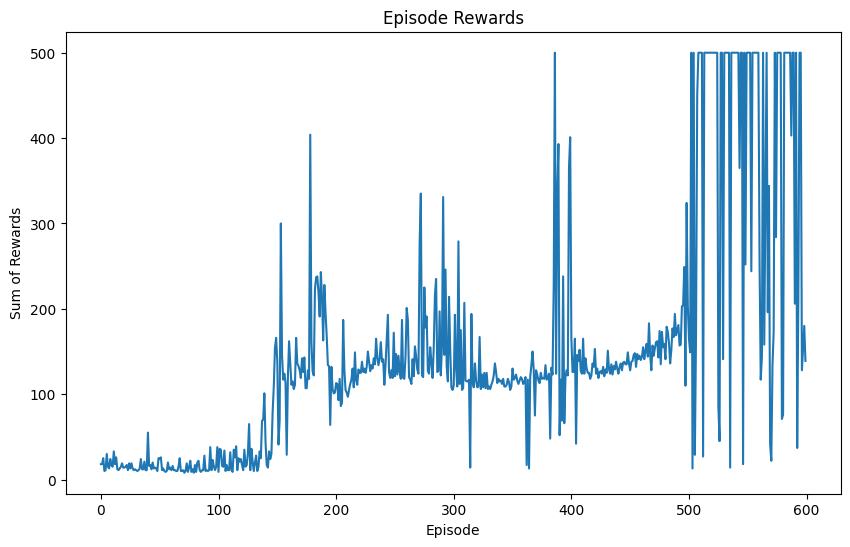

Restoring best weights from training episode 512.


In [ ]:
agent.train(restore_best_weights=True)

### V. Evaluate Agent

In [ ]:
_ = agent.evaluate()

+---------+----------------+
| Episode | Sum of Rewards |
+---------+----------------+
|   1.0   |     500.0      |
|   2.0   |     500.0      |
|   3.0   |     500.0      |
|   4.0   |     500.0      |
|   5.0   |     500.0      |
|   6.0   |     500.0      |
|   7.0   |     500.0      |
|   8.0   |     500.0      |
|   9.0   |     500.0      |
|  10.0   |     500.0      |
+---------+----------------+
Average total rewards over 10 episodes: 500.0


We can see that through training, we can see our agent improved its strategy and performance of Cart Pole through training. We see this in the increase in episode rewards during our evaluation episodes. The maximum reward per episode that the environment offers is 500 (500 time steps). We are reaching this reward on most of our simulation runs!

## J. Solve Problem

We will now see if we "solved" the original problem (average greater than or equal 195.0 total rewards over 100 consecutive episodes).

In [ ]:
average_total = agent.evaluate(100, verbose=False)
print(f'Average total rewards for 100 episodes: {average_total}\nSolved: {average_total >= 195.0}')

Average total rewards for 100 episodes: 500.0
Solved: True


Not only did we solve the problem, we maximized the total possible rewards for every single episode! This means our agent is as good as it can possibly be! That is the power of Deep Q-Learning.

> **[Click to Access Course Homepage](https://github.com/danplotkin/mastering_rl/tree/main?tab=readme-ov-file#mastering-reinforcement-learning-theory-math-and-python)**